# Javad M. Rad

# Churn Prediction

> Churn prediction is detecting which customers are likely to cancel their subscription to a service based on how they use the service. By leveraging Machine Learning techniques, you will be able to anticipate potential churners who are about to abandon your services and take an appropriate marketing action for each individual customer to maximize the chance of retaining the customer.

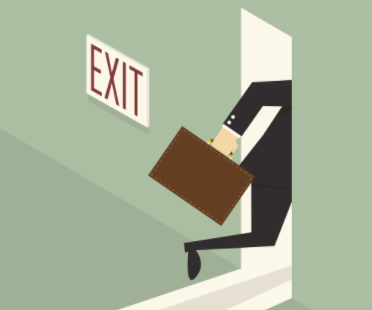

# Importing packages
Let's start with importing required packages.

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier as cat
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve, confusion_matrix

In [ ]:
# Loading the data set into a pandas data frame

print(os.listdir("../input"))
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Exploratory Data Analysis & Feature Engineering
It's time to go through the EDA steps to inspect the data and have an overview of column's data types, values, missing values, outliers, etc.

## Shape, Columns, Types, and Null Values

In [ ]:
df.info()

The shape is (7043, 21) in 3 types and no null values so far.

In [ ]:
df.head()

In order to get the gist of the data, kaggle provided sufficient description of each attribute and the business case itself.

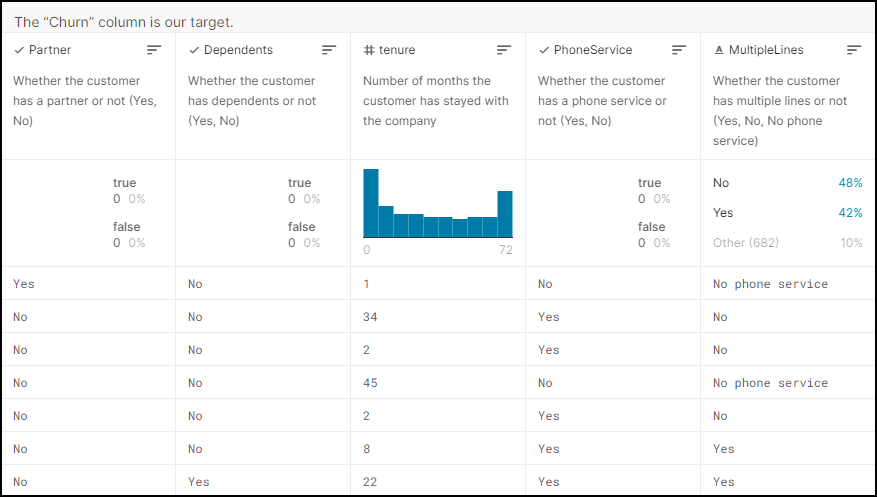

In [ ]:
# Checking the unique values of the columns:

for col in df:
    print('\n',col,': ', df[col].unique())

## Visualization
To have a better data understanding:

In [ ]:
# Illustrating the values and count of attributes using plots:

label_SenCit = df['SeniorCitizen'].unique()
value_SenCit = df['SeniorCitizen'].value_counts() / len(df) * 100

label_gen = df['gender'].unique()
value_gen = df['gender'].value_counts() / len(df) * 100

label_Part = df['Partner'].unique()
value_Part = df['Partner'].value_counts() / len(df) * 100

label_Dep = df['Dependents'].unique()
value_Dep = df['Dependents'].value_counts() / len(df) * 100

fig = plt.figure()

ax1 = fig.add_axes([0, 0, 0.5, 0.5], aspect=2)
ax1.pie(value_SenCit, textprops={'size': 14}, autopct='%1.1f%%', labels=label_SenCit, radius = 2.2)

ax2 = fig.add_axes([0.8, 0, 0.5, 0.5], aspect=2)
ax2.pie(value_gen, textprops={'size': 14}, autopct='%1.1f%%', labels=label_gen, radius = 2.2)

ax3 = fig.add_axes([1.6, 0, 0.5, 0.5], aspect=2)
ax3.pie(value_Part, textprops={'size': 14}, autopct='%1.1f%%', labels=label_Part, radius = 2.2)

ax4 = fig.add_axes([2.4, 0, 0.5, 0.5], aspect=2)
ax4.pie(value_Dep, textprops={'size': 14}, autopct='%1.1f%%', labels=label_Dep, radius = 2.2)

ax1.set_title('SeniorCitizen', loc='center', pad = 100, fontdict={'fontsize':18})
ax2.set_title('gender', loc='center', pad = 100, fontdict={'fontsize':18})
ax3.set_title('Partner', loc='center', pad = 100, fontdict={'fontsize':18})
ax4.set_title('Dependents', loc='center', pad = 100, fontdict={'fontsize':18})

plt.show()

In [ ]:
# Check the balance of class labels:

label_Churn = df['Churn'].unique()
value_Churn = df['Churn'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.bar(label_Churn, value_Churn, color= 'purple', width = 0.6)
ax.set_title('Churn (Class label)', loc='center', pad = 40, fontdict={'fontsize':18})
plt.show()

Clearly, the data is imbalance and needs consideration of choosing classifier and evaluation measures.
According to attributes' description and type of data from the primary check, there are 3 attributes of numerical type namely 'tenure', 'MonthlyCharges', 'TotalCharges'.
TotalCharges is string in data set and needs to be converted into numerical type as follows:

In [ ]:
# Remove leading and tailing characters such as whitespace, tab, etc.
df['TotalCharges'] = df['TotalCharges'].str.strip()

# Convert the column from string to number
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

## Checking and Handling Null Values

In [ ]:
# Since, non-numeric/Alphabetic strings can not be converted to numeric, it will cause to NaN values. So, it is the time to check the null values of 'TotalCharges' again:
print('Count of null values:', df['TotalCharges'].isnull().sum())

# Index of NaN values of 'TotalCharges':
index_na = df[df['TotalCharges'].isnull()].index.tolist()
print('\nindex:', index_na)

In [ ]:
# Checking the rows with Nan value in 'TotalCharges' to handle:
df.iloc[index_na,:].head(11)

A short inspection shows that 'TotalCharges' = 'tenure' * 'monthlyCharges' and it makes sense. In current situation, as shown above, for all the rows with Nan TotalCharges value, tenure is equal to 0. It mean that such customers are new ones. With such reasoning, the most appropriate value for Nan values of 'TotalCharges' would be 0. Dropping these rows can be an alternative. Change them all to 0 as follows and re-check if it is done:

In [ ]:
# All the Nan values will be replaced by zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)
print('Count of null values:', df['TotalCharges'].isnull().sum())

## Attribute Encoding
Most of the attributes of the data frame are categorical ones and need to be numeric values in order to be handled by many ML classifiers. LabelEncoding is an appropriate teqnique for such a transformation. LabelEncoding replaces categorical feature values with integers. Another solution is One-hot Encoding in which a categorical attribute is transformed to one or more binary attributes. 

In [ ]:
# LabelEncoding categorical columns:

cat_col = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling','Contract', 'PaymentMethod', "Churn"]

df[cat_col] = df[cat_col].apply(LabelEncoder().fit_transform)
df.head()

In [ ]:
# # One-hot encoding categorical columns (It is an alternative method for LabelEncoding)

# df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=[
#     'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
#     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
#     'StreamingMovies', 'PaperlessBilling', 'Contract', 'PaymentMethod'], drop_first=True)

In [ ]:
df.info()

## Feature Importance
> Feature Importance is the (normalized) total reduction of the impurity criterion brought by that feature. The higher, the more important the feature.

In [ ]:
DTC = RandomForestClassifier(random_state=4)

X = df.drop(['Churn', 'customerID'] , axis=1)
Y = df['Churn']

feature_imp = DTC.fit(X, Y).feature_importances_
label_feature_imp = X.columns


sort_imp = pd.Series(data=feature_imp, index=label_feature_imp).sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.title("Feature Importance", fontsize=18)
ax = sns.barplot(y=sort_imp.index, x=sort_imp.values, palette="rocket", orient='h')
ax.set_xlabel('feature Importance',fontsize=16);
ax.set_ylabel('Feature',fontsize=16);
plt.show()

TotalCharges, MonthlyCharges, and tenure are in the top 3 of feature importance list.

## Correlation
At this step, data is cleaned. It is time to check the correlation between the attributes:

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize =(18, 14))
sns.heatmap(corrmat, ax = ax, cmap ="Purples", linewidths = 0.1, annot=True)
plt.show()

The strongest positive correlation is between tenure and TotalCharges which stands by 83%.
tenure and Contract correlation get the next major share in our heatmap with 67%.
Last but not least, correlation with share greater than 50% goes to TotalCharge and MonthlyCharges with 65%.

## Checking Outliers
Outliers are data points that are far from other data points. In other words, they’re unusual values in dataset. Outliers are problematic for many statistical analyses because they can cause tests to either miss significant findings or distort real results.
Two of the most common methods to detect outliers are using ***boxplots*** and ***z-score*** test.
In boxplot, The data points less than (Q1 - 1.5 * IQR) and greater than (Q3 + 1.5 * IQR) are recognized as outliers and will be illustrated as individual points in boxplot.
Z-score method assumes that data follows normal probability distribution. With such an assumption, it finds the points out of the range [mean - 3 * std , mean + 3 * std] as outliers. In our data set, the histograms of real-value attributes show that the probability distribution of the data is not normal. So, Z-score is not applicable to our case as the following histograms approve:

In [ ]:
# Plotting the histograms of the real-vale attributes

value_ten = df['tenure']
value_Mon = df['MonthlyCharges']
value_Tot = df['TotalCharges']

fig = plt.figure()

ax1 = fig.add_axes([0.5, 0, 0.7, 0.7])
ax1.hist(value_ten, color='red', bins = 20)

ax2 = fig.add_axes([1.4, 0, 0.7, 0.7])
ax2.hist(value_Mon, color='red', bins = 20)

ax3 = fig.add_axes([2.3, 0, 0.7, 0.7])
ax3.hist(value_Tot, color='red', bins = 20)

ax1.set_title('tenure histogram', loc='center', pad = 20, fontdict={'fontsize':18})
ax2.set_title('MonthlyCharges histogram', loc='center', pad = 20, fontdict={'fontsize':18})
ax3.set_title('TotalCharges histogram', loc='center', pad = 20, fontdict={'fontsize':18})
plt.show()

The histograms of the real-value attributes approve that they do not follow normal probalility distribution. We can continue outlier detection with the boxplots.

In [ ]:
# Boxplots to check outliers

fig, axs = plt.subplots(1, 3)

axs[0].boxplot(df['tenure'], widths = 0.4, patch_artist=True)
axs[0].set_title('tenure')

axs[1].boxplot(df['MonthlyCharges'], widths = 0.4, patch_artist=True)
axs[1].set_title('MonthlyCharges')

# change outlier point symbols
axs[2].boxplot(df['TotalCharges'], widths = 0.4, patch_artist=True)
axs[2].set_title('TotalCharges')
# fig, ax = plt.subplots()
# ax.boxplot(data)

fig.subplots_adjust(left=0.5, right=2, bottom=0.1,
                    top=1, hspace=20, wspace=1)

plt.show()

No outlier observed!


# Business Insight
In order to see the relation between the real-value attributes and class labels, the percentage of churned customers are checked versus cumulative TotalCharges. Interesting related facts! First diagram, the relation between the percentage of churned customers and their cumulative TotalCharges shows that almost 53% of the customers whose TotalCharges is less than 100 are churned, that is, the less customer's TotalCharges implies the higher churn rate.

In [ ]:
# Churn rate versus customer's TotalCharges

x_value = np.sort(df['TotalCharges'].unique())
c = [len(df[(df.TotalCharges<=i) & (df.Churn==1)])/len(df[(df.TotalCharges<=i)])*100 for i in x_value]
plt.figure(figsize=(12,7))
plt.xlabel('Cumulative TotalCharges', fontsize=12)
plt.ylabel('Percentage of Churned Customers', fontsize=12)
plt.title('Percentage of Churned Customers Respect to Cumulative TotalCharges', fontsize=14)
plt.grid(True)
plt.plot(x_value, c, color='blue', linewidth=2)
plt.show()

The second inquiry investigates the relation between the percentage of churned customers and corresponding cumulative tenure. It states that around 63% of the customers who have tenure less 1 month are churned, that is, trying to retain the customer for longer makes it less probable to abandon the business.

In [ ]:
# Churn rate versus tenure

x_value = np.sort(df['tenure'].unique())
c = [len(df[(df.tenure<=i) & (df.Churn==1)])/len(df[(df.tenure<=i)])*100 for i in x_value]
plt.figure(figsize=(12,7))
plt.xlabel('Cumulative tenure', fontsize=12)
plt.ylabel('Percentage of Churned Customers', fontsize=12)
plt.title('Percentage of Churned Customers Respect to Cumulative tenure', fontsize=14)
plt.grid(True)
plt.plot(x_value, c, color='blue', linewidth=2)
plt.show()

Finally, the third investigation shows that less than only 10% of customers with low MonthlyCharges will abandon the company. In other words, more than 90% of the customers whose MonthlyCharges is 20 are ready to keep on subscribing the services of the business.

In [ ]:
# Churn rate versus customer's MonthlyCharges

x_value = np.sort(df['MonthlyCharges'].unique())
c = [len(df[(df.MonthlyCharges<=i) & (df.Churn==1)])/len(df[(df.MonthlyCharges<=i)])*100 for i in x_value]
plt.figure(figsize=(12,7))
plt.xlabel('Cumulative MonthlyCharges', fontsize=12)
plt.ylabel('Percentage of Churned Customers', fontsize=12)
plt.title('Percentage of Churned Customers Respect to Cumulative MonthlyCharges', fontsize=14)
plt.grid(True)
plt.plot(x_value, c, color='blue', linewidth=2)
plt.show()

# Building and Evaluating Model

## k-Fold Cross-Validation
> It is a standard resampling method for estimating the performance of a machine learning model on data set. Shortly, this approach involves randomly dividing the data set into k groups or folds, of approximately equal size. Each folds is treated as a validation set, while the model is fit on the remaining k − 1 folds.


## Why Cross-Validation?
> It results in a ***less biased*** or ***less optimistic*** estimate of the model performance than other methods, such as a simple train/test split. Because it ensures that every observation from the original data set has the ***chance of appearing in training and test set***.

In [ ]:
# Split data into input and output (No need to split into train and test. It is automatically handled by cross validation)

X = df.drop(['Churn', 'customerID'] , axis=1)
Y = df['Churn']

In [ ]:
# Try classifiers from various types such as linear, tree, ensemble, neighborhood, voting (ensemble), margin-based, etc.

# LOG = LogisticRegression(n_jobs = -1)
# DTC = DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10)
ADA = AdaBoostClassifier(random_state=1, n_estimators=90, learning_rate=0.9)
# KNN = KNeighborsClassifier(n_neighbors=7, weights='distance')
# BAG = BaggingClassifier(random_state=1)
# VOTE = VotingClassifier(estimators=[('LOG', LOG), ('ADA', ADA)], n_jobs = -1, voting='soft', weights=[2, 5])
# XGB = xgb.XGBClassifier()
# CAT = cat(learning_rate=1, depth=10, loss_function='CrossEntropy')
# SVM = SVC(class_weight='balanced')

## Hyperparameter Tuning

In [ ]:
# Use GridSearchCV for Hyperparameter tuning in order to determine the optimal values for the given model.

par = {'n_estimators':[80, 90, 100],
       'learning_rate':[0.8, 0.9]}
GS = GridSearchCV(ADA, param_grid=par, cv=5, scoring='accuracy', n_jobs=-1)
GS.fit(X, Y)
print('Best score of grid search:',GS.best_score_)
print('Best Parameters:', GS.best_params_)

Employing various classifiers with considering hyperparameter tuning for this data set shows that AdaBoostClassifier results in one of the highest performance measure with a fair computational expense.

## Evaluation Measures

In [ ]:

scores = cross_validate(ADA, X, Y, cv=5, scoring=['accuracy','precision','recall','f1', 'roc_auc'], n_jobs = -1)
print('Measures using k-fold cross validation:\n')

print('accuracy of folds:', scores['test_accuracy'])
print('overall accuracy:',scores['test_accuracy'].mean())

print('\nprecision of folds:', scores['test_precision'])
print('overall precision:',scores['test_precision'].mean())

print('\nrecall of folds:', scores['test_recall'])
print('overall recall:',scores['test_recall'].mean())

print('\nf1 of folds:', scores['test_f1'])
print('overall f1:',scores['test_f1'].mean())

print('\nroc_auc of folds:', scores['test_roc_auc'])
print('overall roc_auc:',scores['test_roc_auc'].mean())

We can also go through the typical train/test split.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2) # 80% train, 20% test

ADA.fit(X_train,Y_train)
preds = ADA.predict(X_test)
print('Measures using Train/Test split:')
print('\naccuracy:', accuracy_score(Y_test, preds))
print('\nprecision:', precision_score(Y_test, preds))
print('\nrecall:', recall_score(Y_test, preds))
print('\nf1:', f1_score(Y_test, preds))
print('\nroc_auc_score:', roc_auc_score(Y_test, preds))
print('\nconfusion matrix:\n', confusion_matrix(Y_test, preds))

plot_roc_curve(ADA, X_test, Y_test)

plt.show()

The ROC curve above implies that the ratio TP rate/FP rate is fairly good.